# Data processing 
from initial_micro_data_wrangling as netcdf

In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat

In [2]:
arctic_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/arctic_mmp.nc"
arctic_dataset = Dataset(arctic_nc)
arctic_ds = xr.open_dataset(arctic_nc)

In [3]:
# trace back depth as a variable from pressure (how useful?)
arctic_ds["z"] = -arctic_ds.PRESSURE # pressure in dbar to z

## Bin data

In [4]:
# correlate depth samples to actual depth
# assume that pressure (decibars) of the water correlates to the depth (m)
multiply_factor = arctic_ds.PRESSURE.max().item()/arctic_ds.depth.max().item()
arctic_ds["depth"] = arctic_ds["depth"]*multiply_factor

In [5]:
bin_ds = arctic_ds
# group data by depth bins
# adjust the labels to reflect the start of each interval
bin_size = np.arange(0, 300.1, 1)
bin_labels = [edge for edge in bin_size[:-1]]
grouped = bin_ds.groupby_bins('depth', bin_size, labels=bin_labels)
# calculate mean of each bin
binned_data = grouped.mean(dim='depth')
binned_data = binned_data.rename({'depth_bins': 'depth'})
binned_data

<xarray.Dataset>
Dimensions:      (depth: 300, profiles: 871, single: 1)
Coordinates:
  * depth        (depth) float64 0.0 1.0 2.0 3.0 4.0 ... 296.0 297.0 298.0 299.0
Dimensions without coordinates: profiles, single
Data variables:
    LATITUDE     (depth, profiles, single) float64 65.23 65.24 ... 65.73 65.73
    LONGITUDE    (depth, profiles, single) float64 -166.6 -166.6 ... -168.8
    TIME         (depth, profiles, single) float64 7.362e+05 ... 7.362e+05
    EPSILON      (depth, profiles) float64 nan nan nan nan ... nan nan nan nan
    PRESSURE     (depth, single) float64 0.625 1.625 2.625 ... 297.6 298.6 299.6
    PSAL         (depth, profiles) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TEMPERATURE  (depth, profiles) float64 nan nan nan 13.6 ... nan nan nan nan
    z            (depth, single) float64 -0.625 -1.625 -2.625 ... -298.6 -299.6

Text(0.5, 0, 'Temperature')

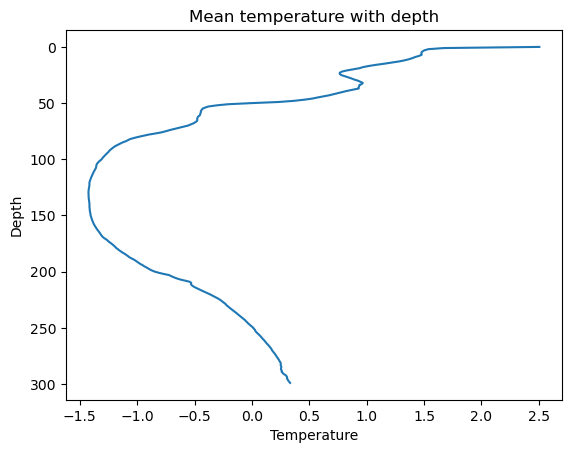

In [6]:
plt.plot(binned_data.TEMPERATURE.mean(dim="profiles"),binned_data.depth)
plt.gca().invert_yaxis()  # invert the y-axis (depth axis)
plt.title("Mean temperature with depth")
plt.ylabel("Depth")
plt.xlabel("Temperature")

In nc dataset, can find time, lat, lon, epsilon, pressure, psal, temperature.
dimensions for this dataset are lengths, profiles and depth

lit review on Arctic and CC and beaufort sea

Understabding Arctic turbulence: beaufort gyre

The Arctic Ocean's beaufort gyre

## Convert time format

In [14]:
arctic_ds

<xarray.Dataset>
Dimensions:          (length_t: 93, single: 1, length_tm: 9, length_c: 18,
                      length_o: 52, length_i: 3, profiles: 871, depth: 1201)
Coordinates:
  * depth            (depth) float64 0.0 0.25 0.5 0.75 ... 299.5 299.8 300.0
Dimensions without coordinates: length_t, single, length_tm, length_c,
                                length_o, length_i, profiles
Data variables: (12/13)
    title            (length_t, single) |S1 ...
    time             (length_tm, single) |S1 ...
    chief_scientist  (length_c, single) |S1 ...
    data_originator  (length_o, single) |S1 ...
    institution      (length_i, single) |S1 ...
    LATITUDE         (profiles, single) float64 ...
    ...               ...
    TIME             (profiles, single) float64 ...
    EPSILON          (profiles, depth) float64 ...
    PRESSURE         (depth, single) float64 0.0 0.25 0.5 ... 299.5 299.8 300.0
    PSAL             (profiles, depth) float64 ...
    TEMPERATURE      (profiles, depth) float64 ...
    z                (depth, single) float64 -0.0 -0.25 -0.5 ... -299.8 -300.0

In [ ]:
import datetime

days_since_reference = 736203

# Define the reference date
reference_date = datetime.datetime(1900, 1, 1)

# Calculate the target date
target_date = reference_date + datetime.timedelta(days=days_since_reference)

print("Input days since reference:", days_since_reference)
print("Target date:", target_date)

In [16]:
arctic_ds.TIME.values

array([[736203.20539352],
       [736203.20611111],
       [736203.20657407],
       [736203.2159375 ],
       [736207.98364583],
       [736208.02127315],
       [736209.19596065],
       [736209.22078704],
       [736209.23354167],
       [736209.24612269],
       [736209.25725694],
       [736209.26709491],
       [736209.27818287],
       [736209.28928241],
       [736209.30063657],
       [736209.31289352],
       [736209.32508102],
       [736209.33636574],
       [736209.3477662 ],
       [736209.36048611],
       [736209.37292824],
       [736209.38469907],
       [736209.39587963],
       [736209.40795139],
       [736209.41934028],
       [736209.42998843],
       [736209.44090278],
       [736209.45196759],
       [736209.46484954],
       [736209.47659722],
       [736209.48829861],
       [736209.50021991],
       [736209.5256713 ],
       [736209.53640046],
       [736209.54891204],
       [736209.56013889],
       [736209.57206019],
       [736209.5840625 ],
       [7362

## Convert to standard size of dataframe
correct variable names

# apply mask to get rid of rows with NaN values in var2 and var3
mask = xr.ufuncs.logical_not(xr.ufuncs.isnan(binned_data['TEMPERATURE']) | xr.ufuncs.isnan(binned_data['PSAL']) | xr.ufuncs.isnan(binned_data['EPSILON']))
ds_masked = binned_ds.where(mask, drop=True)

## Change variable names and save for preprocessing

In [9]:
binned_data = binned_data.rename({'PSAL': 'S', 'TEMPERATURE': 'T', 'LONGITUDE': 'longitude', 'LATITUDE':'latitude', "EPSILON":"eps", "PRESSURE":"P"})
binned_data.coords["depth"] = binned_data.coords["depth"].astype(int)
binned_data = binned_data.assign_coords(longitude=binned_data['longitude'], latitude=binned_data['latitude'])
binned_data = binned_data.rename_dims({"profiles": "profile"})

In [10]:
binned_data

<xarray.Dataset>
Dimensions:    (depth: 300, profile: 871, single: 1)
Coordinates:
    latitude   (depth, profile, single) float64 65.23 65.24 ... 65.73 65.73
    longitude  (depth, profile, single) float64 -166.6 -166.6 ... -168.8 -168.8
  * depth      (depth) int64 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
Dimensions without coordinates: profile, single
Data variables:
    TIME       (depth, profile, single) float64 7.362e+05 ... 7.362e+05
    eps        (depth, profile) float64 nan nan nan nan nan ... nan nan nan nan
    P          (depth, single) float64 0.625 1.625 2.625 ... 297.6 298.6 299.6
    S          (depth, profile) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    T          (depth, profile) float64 nan nan nan 13.6 nan ... nan nan nan nan
    z          (depth, single) float64 -0.625 -1.625 -2.625 ... -298.6 -299.6

In [14]:
binned_data.to_netcdf('/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/arctic_mix.nc')

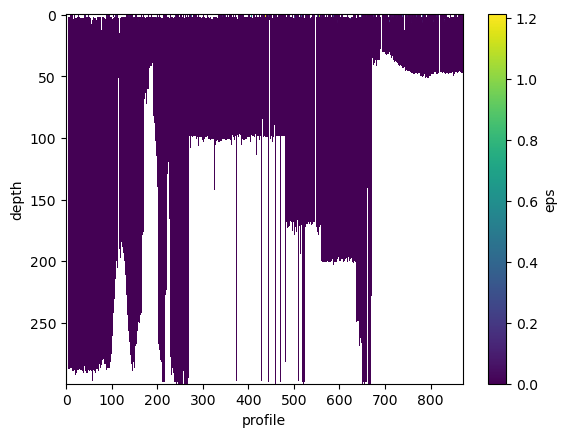

In [11]:
binned_data.eps.plot()
plt.gca().invert_yaxis()

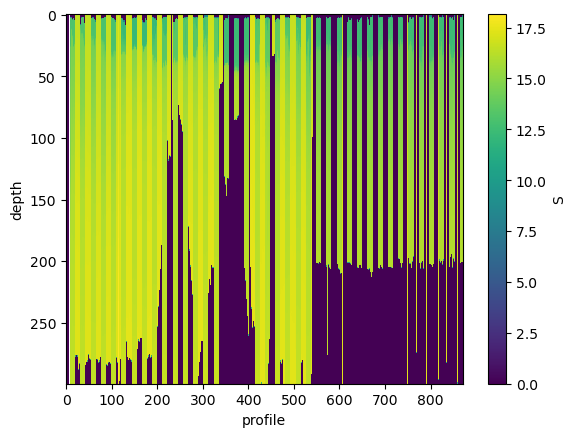

In [12]:
binned_data.S.plot()
plt.gca().invert_yaxis()